<a href="https://www.kaggle.com/code/avikumart/computervision-intel-image-classification-project?scriptVersionId=102589767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this notebook, we will build `image classification models` to classify 6 categories of images; namely buildings, forest, glacier, mountain, sea, and street. image classification is one of the popular problems of computer vision challanges.

In this project of image classification we will try to build model from training dataset to classify and label images of six categories by users.

**Use-case:** Popular use-case of such model is `image collections` in mobile app wherein user captures images of scenaries, and model correctly labels & classifies into their respective class.

**Problem statement:** Build model that classifies 6 categories images from intel images dataset accuratly to label unlabeled dataset & classify them correctly

**Steps to be followed to solve this problem:**
1. Load the dataset
2. Label the dataset
3. Visualize and explore the dataset
4. Train the Deep neural net with CNN layers
5. Train using pre-trained models from keras models
6. Classify unseen dataset of images into their respective class and label them

# Table of contents

1. [Label and load dataset](#data)
2. [Pre-process and explore image dataset](#images)
3. [Deep neural network model with CNN layer explanation](#cnn)]
4. [Prediction on unseen data](#predict)
5. [Loss and accuracy curves](#lossacc)
6. [Error analysis of model](#error)
7. [Model trainning using VGG16 as base](#vgg16)
  - [Loss and accuracy curves of model2](#loss2)
  - [Milabels data/Errors analysis](#mis2)
  - [Prediction on unseen data to using model2](#unseen)
8. [Visualizing what Convnets learn](#conv)
  - [Visualizing every activation of every channel](#activ)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image

# 1. Label and load the dataset

<a id="data"></a>

In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dir = '../input/intel-image-classification/seg_test/seg_test'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred'

In [3]:
# assign class labels
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2512
2382
2191
2274
2271
2404


In [5]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [6]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:18<00:00, 132.92it/s]


Images file have been loaded
loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 143.84it/s]


Images file have been loaded


In [7]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [8]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

# 2. Pre-process and explore image datasets

<a id="images"></a>

In [9]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [10]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)

In [11]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [12]:
# keeping 6000 data instances for training and testing our model
train_images = train_images[:6000]
train_labels = train_labels[:6000]

In [13]:
test_images = test_images[:1400]
test_labels = test_labels[:1400]

In [14]:
# normalize the images dataset
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [15]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

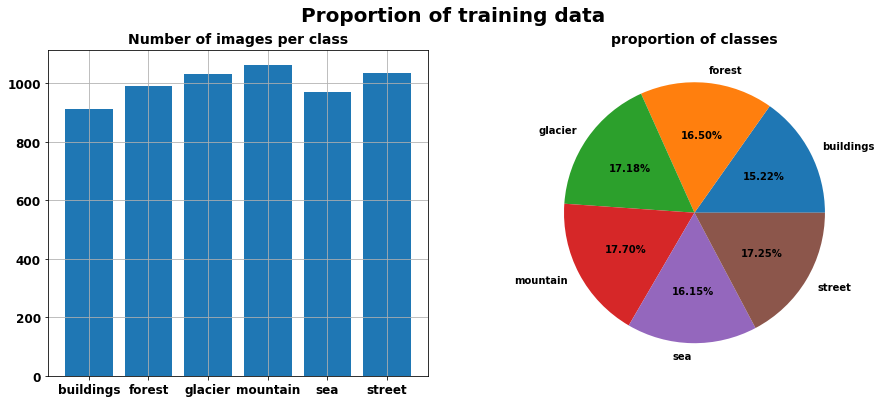

In [16]:
final_s = proportion_labels(train_labels, "training")

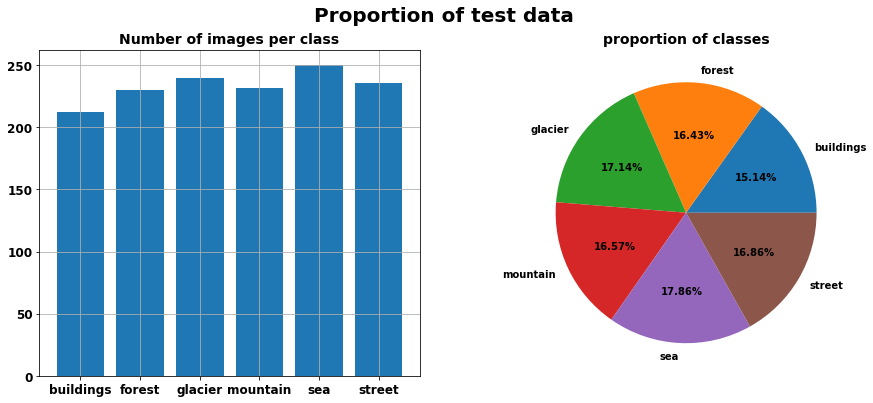

In [17]:
test_d = proportion_labels(test_labels, "test")

### Observation:

Our both training and test datasets are more or less equally distributed as we shuffled the dataset after loading and labeling

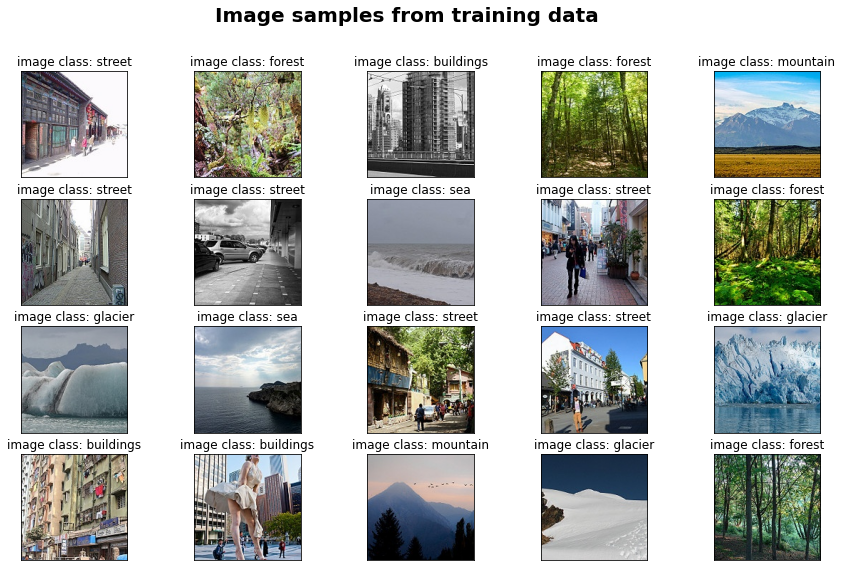

In [18]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

# 3. Deep neural network model using CNN layers

<a id="cnn"></a>

### Feature extraction process of CNN

- The fundamental difference between a densely connected layer and a convolution layer is that, Dense layers learn global patterns in their input feature space, whereas convolution layers learn local patterns by small windows of feature map.

- Feature extraction performed by CNN consists of 3 basic operations.
1. **Filter:** an image for a perticular feature (Convolution)
2. **Detect:** feature within the filtered image (ReLU)
3. **Condense:** image to enhance the features (Maxpooling)

*Ref:* Deep learning with Python by Francois Chollet, [Kaggle learn's Convolution and relu chapter](https://www.kaggle.com/code/ryanholbrook/convolution-and-relu)

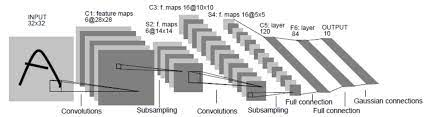

### CNN2D layer arguments:

**tf.keras.layers.Conv2D**(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

**Important arguments and their description**

**filters** - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)

**kernel_size** - An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions

**strides** - An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.

**padding** - one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.

**activation** - Activation function to use. If you don't specify anything, no activation is applied

In [19]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

2022-08-05 11:47:21.106196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

2022-08-05 11:47:21.212414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 11:47:21.213286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 11:47:21.214942: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 11:47:21.215259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [20]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

2022-08-05 11:47:23.782550: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-08-05 11:47:25.564033: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-08-05 11:47:26.876757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-08-05 11:47:28.467192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - ETA: 0s - loss: 1.4227 - accuracy: 0.4120

2022-08-05 11:47:36.799557: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 378000000 exceeds 10% of free system memory.
2022-08-05 11:47:37.255691: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 378000000 exceeds 10% of free system memory.


47/47 [==============================] - 11s 78ms/step - loss: 1.4227 - accuracy: 0.4120 - val_loss: 1.3292 - val_accuracy: 0.4621


2022-08-05 11:47:38.665673: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/15
47/47 [==============================] - 2s 52ms/step - loss: 1.1605 - accuracy: 0.5300 - val_loss: 1.1005 - val_accuracy: 0.5521
Epoch 3/15
47/47 [==============================] - 2s 47ms/step - loss: 1.0458 - accuracy: 0.5857 - val_loss: 1.0052 - val_accuracy: 0.6014
Epoch 4/15
47/47 [==============================] - 3s 55ms/step - loss: 0.9615 - accuracy: 0.6135 - val_loss: 0.9556 - val_accuracy: 0.6286
Epoch 5/15
47/47 [==============================] - 2s 52ms/step - loss: 0.8887 - accuracy: 0.6615 - val_loss: 0.9307 - val_accuracy: 0.6386
Epoch 6/15
47/47 [==============================] - 2s 47ms/step - loss: 0.8379 - accuracy: 0.6848 - val_loss: 1.0426 - val_accuracy: 0.5736
Epoch 7/15
47/47 [==============================] - 2s 48ms/step - loss: 0.8021 - accuracy: 0.6933 - val_loss: 0.7578 - val_accuracy: 0.7214
Epoch 8/15
47/47 [==============================] - 2s 52ms/step - loss: 0.7666 - accuracy: 0.7100 - val_loss: 0.7744 - val_accuracy: 0.7150
Epoch 9/15
47

2022-08-05 11:48:49.534491: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 378000000 exceeds 10% of free system memory.


test loss and accuracy: 0.6377835273742676 0.7549999952316284


### Note:

With 15 epochs and adam optimizer our test dataset accuracy comes around at 76-79% while our train accuracy stood at 80% at max.

This is the case of underfitting. to overcome underfitting, we need more deeper NN model to find highest accuracy. also we need to check where the error lies

In [21]:
# saving model in H5 format
#model.save('image_classifier_cnn1.h5')

In [22]:
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
len(images_paths)

7301

In [23]:
# images path list to numpy array using cv2.imread module
file_array = []

for file in images_paths[:9]:
    files = cv2.imread(file)/255.0 
    file_array.append(files)
    
file_array = np.array(file_array)

# 4. Prediction on unseen image data

<a id="predict"></a>

In [24]:
# vector of prected probability of each class by our model
predictions = model.predict(file_array)
predictions.shape

(9, 6)

In [25]:
# prediciton of 'index 0'image from 'preds_dir' image directory
preds_index = np.argmax(predictions, axis=1)
preds_index

array([4, 5, 3, 0, 3, 0, 3, 2, 4])

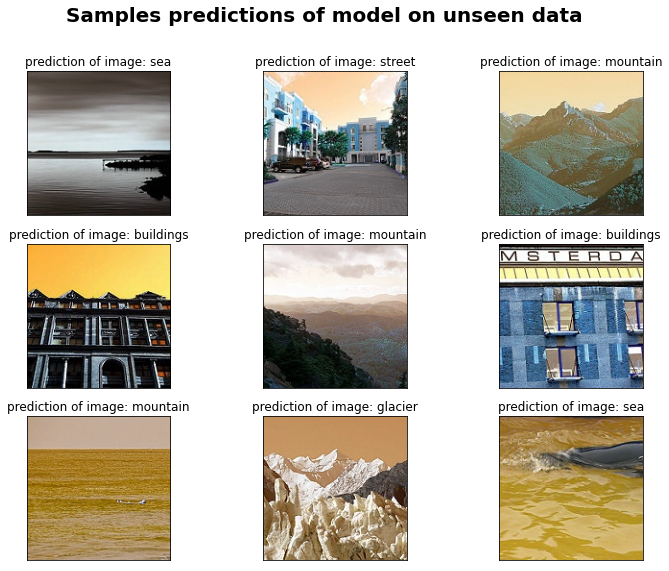

In [26]:
# sample prediciton on unseen data using model
plt.figure(figsize=(12,9))

for idx, i in enumerate(preds_index):
    plt.subplot(3,3, idx+1)
    plt.imshow(file_array[idx])
    plt.title(f"prediction of image: {class_names[i]}")
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')
plt.show()

### Observation:

We can learn that image **index numbers 6 and 7** are not predicted correctly from our prediction dataset. we will do error dataset on validation dataset

# 5. Plot the Loss and accuracy curves

<a id="lossacc"></a>

In [27]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

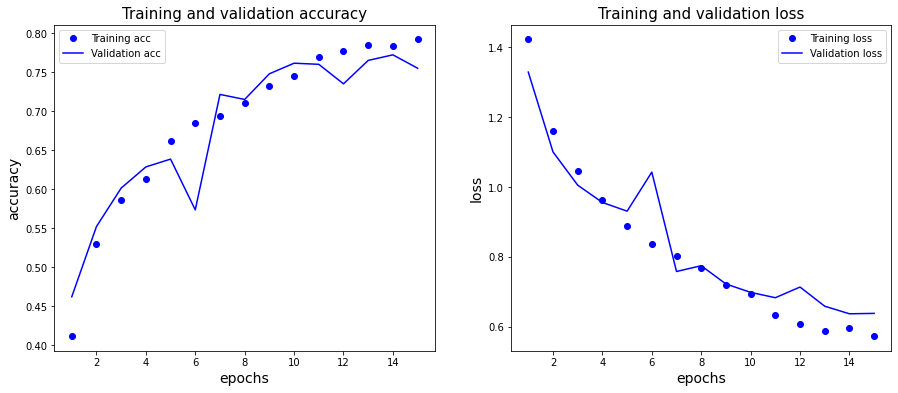

In [28]:
# call the function to plot the curves
plot_loss_accuracy(history)

# 6. Error analysis on test data

<a id="error"></a>

In [29]:
# prediction on validation data to check the errors
preds = model.predict(tst_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

Shape of the prediction indexs (1400, 6)
Shape of predicitons vector: (1400,)


In [30]:
# convert categorical test labels to numpy array of 1 dim
test_list = []
for i in test_labels:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (1400,)


In [31]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):
    # find the  mislabeled images using np.where and return array of mislabled images
    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]
    
    print("Number of total mislabeled images", mislables_labels.shape)
    
    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')   
    
        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()  
    return mislables_labels

Number of total mislabeled images (343,)


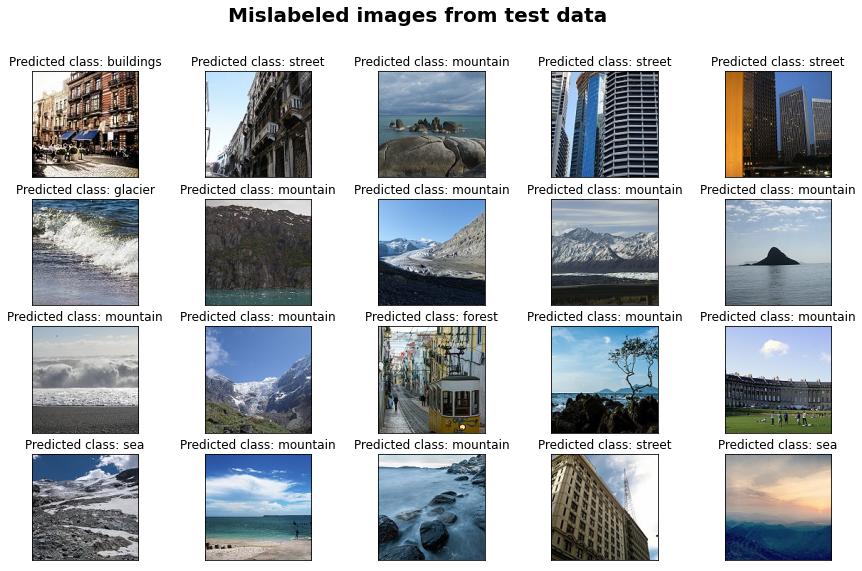

In [32]:
mislables_labels = mislabled_images(class_names, tst_images_norm, test_array, predictions_f)

### Observations:

Model confuses between street with buildings and actual building class

Model confuses sea/glacier with mountains and actual mountains. model classifies them as mountains rathar than sea or glacier

It seems reasonable by seeing these variations that why these images are mislabeled. to mitigate this we have to build more deeper NN model with pre-trained base and increse accuracy of classification.

We won't do data augmentation in this problem, as these are the natural scenary images rather than specifics object images.

# 7. Model training using pre-trained convolutional base VGG16

<a id="vgg16"></a>

**VGG16 ARCHITECTURE:**

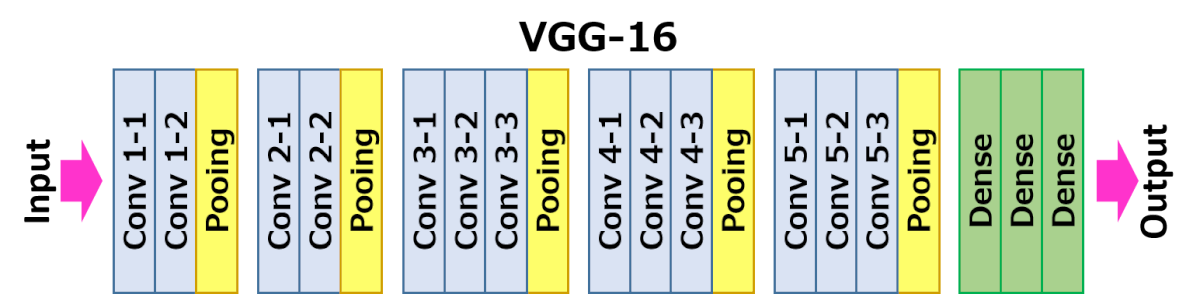

In [33]:
# next up model using pretrained model vgg16 to improve accuracy to 85-90% and machine visualization
# initializing convolutional base of vgg16
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [34]:
# Extract training feature map from vgg16 conv_base
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm) 

In [35]:
# print the shape of output tensors from convolutionla base -vgg16
train_featuremap.shape, test_featuremap.shape

((6000, 4, 4, 512), (1400, 4, 4, 512))

In [36]:
# train the model by adding dense layers on top of extracted features
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(6, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 2,098,950
Trainable params: 2,098,950
Non-trainable params: 0
_________________________________________________________________


In [37]:
# compile the model with 'RMSprop' optimizer
model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [38]:
# fit the model to datr and save the model statistics to result instance
result = model2.fit(train_featuremap, train_labels,
                   batch_size=128,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

# print the final test accuracy and loss
tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

Epoch 1/30
47/47 [==============================] - 1s 9ms/step - loss: 1.3869 - accuracy: 0.4625 - val_loss: 0.9534 - val_accuracy: 0.7543
Epoch 2/30
47/47 [==============================] - 0s 5ms/step - loss: 0.9120 - accuracy: 0.6910 - val_loss: 0.6920 - val_accuracy: 0.7950
Epoch 3/30
47/47 [==============================] - 0s 5ms/step - loss: 0.7178 - accuracy: 0.7575 - val_loss: 0.5788 - val_accuracy: 0.8179
Epoch 4/30
47/47 [==============================] - 0s 5ms/step - loss: 0.6091 - accuracy: 0.7917 - val_loss: 0.5172 - val_accuracy: 0.8350
Epoch 5/30
47/47 [==============================] - 0s 6ms/step - loss: 0.5516 - accuracy: 0.8072 - val_loss: 0.4817 - val_accuracy: 0.8400
Epoch 6/30
47/47 [==============================] - 0s 5ms/step - loss: 0.5130 - accuracy: 0.8242 - val_loss: 0.4513 - val_accuracy: 0.8486
Epoch 7/30
47/47 [==============================] - 0s 5ms/step - loss: 0.4694 - accuracy: 0.8385 - val_loss: 0.4337 - val_accuracy: 0.8514
Epoch 8/30
47/47 [==

### Note:

We gained maximum 87% accuracy using pre-trained model VGG16, which is higher than previous model.

Thus by using more dense CNN layers with dense layers we can get higher accuracy when more information of every image needs to be captured.

In [39]:
# saving model2 with h5 extension
#model2.save("image_classifier_cnn2.h5")

## Loss and accuracy plots of model2

<a id=loss2></a>

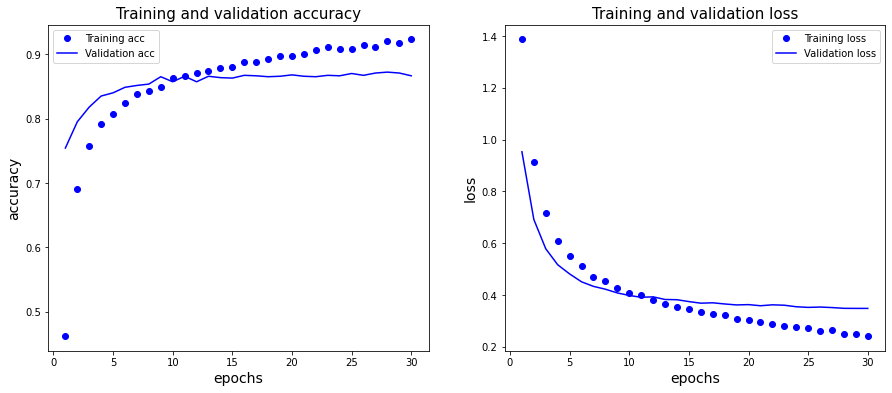

In [40]:
# plotting loss and accuracy curves
plot_loss_accuracy(result)

In [41]:
# create function of samples prediction of training data and build next model with fine-tuning
pred = model2.predict(test_featuremap)
predictions = np.argmax(pred, axis=1)
predictions.shape

(1400,)

## Mislabeled Images by model2

<a id=mis2></a>

Number of total mislabeled images (187,)


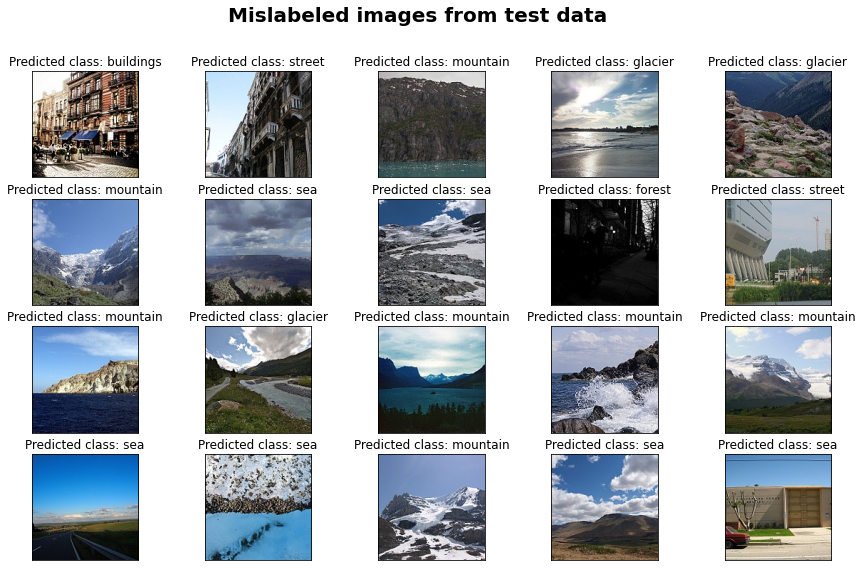

In [42]:
mislables_labels= mislabled_images(class_names, tst_images_norm, test_array, predictions)

### Note:

Model2 has improved a lot than previous model without pretrained base model. we have now onlu 186 images from test dataset that are not labeled correctly

By looking at mislabeled images, we can observe that these images are more or less similar to what has been predicted but images are having dual objects like mountain and glacir, or buildings an street so and so forth. that is the reason we have mis-classification of these images. 

This model still can be used to classify images from users to put into their respective classes.

## Predict labels of unseen data and classify them into their respective class

<a id=unseen></a>

In [43]:
def images_classifier(images_paths, class_names):
    file_array2 = []
    
    for file2 in images_paths:
        files2 = cv2.imread(file2)/255.0 
        file_array2.append(files2)
        
    file_array2 = np.array(file_array2)
    
    # run thorought the convolutional base and then model2
    img_arr = conv_base.predict(file_array2)
    
    # run img_arr of shape (9,4,4,512) through model2
    img_pred = model2.predict(img_arr)
    img_predf = np.argmax(img_pred, axis=1)
    print("shape of the predicted array:", img_predf.shape)
    
    # plot the 20 unseen images and predicted class
    plt.figure(figsize=(17,13))
    
    for idx, i in enumerate(img_predf):
        plt.subplot(4,5, idx+1)
        plt.imshow(file_array2[idx])
        plt.title(f"prediction of image: {class_names[i]}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle("Samples predicition of model2 on unseen data", size=20, weight='bold')
    plt.show()

shape of the predicted array: (20,)


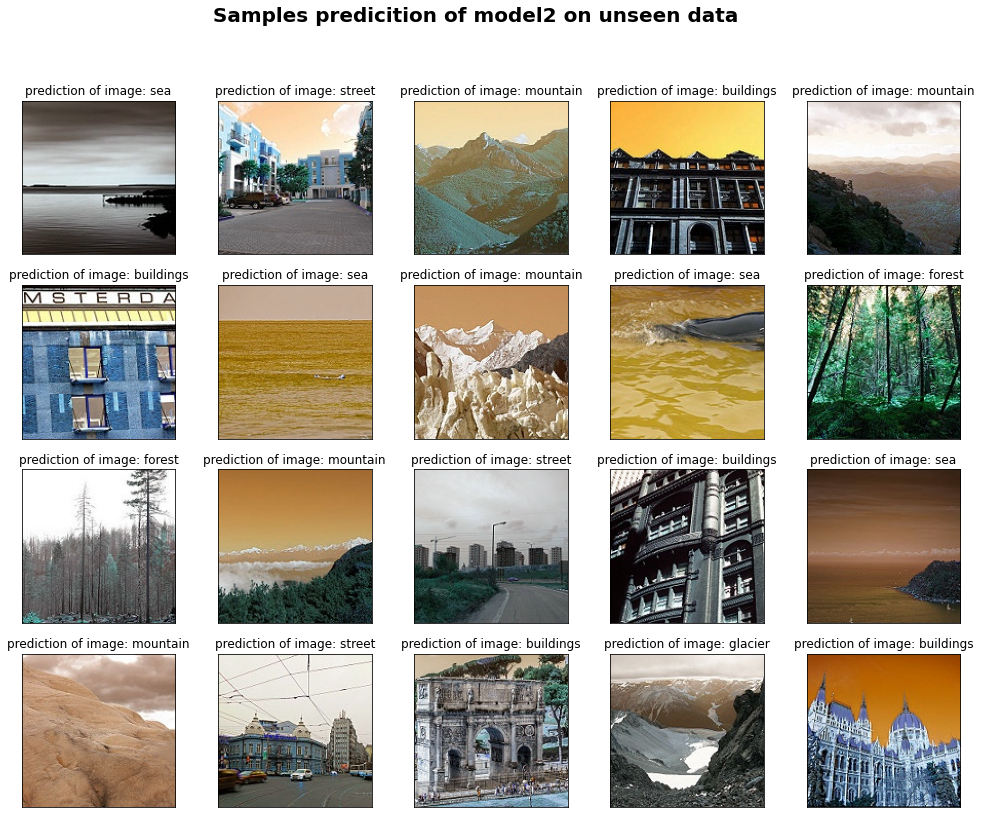

In [44]:
images_classifier(images_paths[:20], class_names)

### Observation:

Here, we can see how model2 using vgg16 as a base performed really well than previous model. model2 could correctly classify every image of first 20 samples. 

It improved from previous errors of buildings/street and mountain/glacier confusions.

# 8. Visualizing what convnets learn

<a id="conv"></a>

There are 3 techniques to visualize how convnets learn featuremap from the input image array.

1. Visualizing intermediate activations
2. Visualizing convnets filters
3. Visualizing heatmaps of class activation in an image

In this section, we will only see first technique of visulizaiton of every activation of an intermediate layers of our model.

*Reference: Deep learning with python by Francois chollet*

## Visualizing intermediate activations

In [45]:
# load the first model we developed using load_model of keras
model3 = load_model('../input/image-clf-model1final/image_classifier_cnn1.h5')
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [46]:
# let's take one simple image from unseen image set 
image_path = '../input/intel-image-classification/seg_pred/seg_pred/10092.jpg'

# load and preprocess the image instance
img = image.load_img(image_path, target_size=(150,150))
print("Data type of image instance is: ", type(img))
img_tensor = image.img_to_array(img) # convert to numpy array
img_tensor = np.expand_dims(img_tensor, axis=0) # expand dimensions to 4D
img_tensor /= 255. 
print("Shape of image tensor:", img_tensor.shape)

Data type of image instance is:  <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape of image tensor: (1, 150, 150, 3)


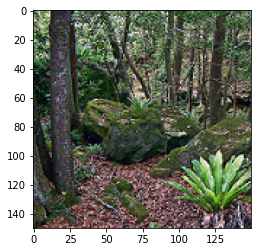

In [47]:
# visualize the image
plt.imshow(img_tensor[0])
plt.show()

In [48]:
# extract an output layers from loaded model3
layer_outputs = [layer.output for layer in model3.layers[:10]]
print("Layer outputs:\n",layer_outputs)

# create a activation model instance with output of each layer given the input tensor
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)
print("===============================================================")
# predict the outputs of each layer given the input of an image tensor
activations = activation_model.predict(img_tensor) # returns the list of 10 arrays
first_layer_active = activations[0]
first_layer_active.shape

Layer outputs:
 [<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d')>, <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d')>, <KerasTensor: shape=(None, 72, 72, 32) dtype=float32 (created by layer 'conv2d_1')>, <KerasTensor: shape=(None, 36, 36, 32) dtype=float32 (created by layer 'max_pooling2d_1')>, <KerasTensor: shape=(None, 34, 34, 64) dtype=float32 (created by layer 'conv2d_2')>, <KerasTensor: shape=(None, 17, 17, 64) dtype=float32 (created by layer 'max_pooling2d_2')>, <KerasTensor: shape=(None, 15, 15, 64) dtype=float32 (created by layer 'conv2d_3')>, <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'max_pooling2d_3')>, <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'conv2d_4')>, <KerasTensor: shape=(None, 2, 2, 64) dtype=float32 (created by layer 'max_pooling2d_4')>]


(1, 148, 148, 32)

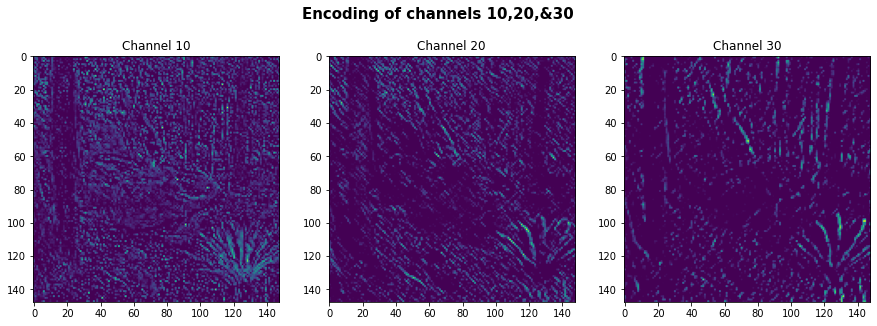

In [49]:
# now let's visualize one of the the channels out of total 32 channels
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(first_layer_active[0,:,:,10])
plt.title("Channel 10")
plt.subplot(1,3,2)
plt.imshow(first_layer_active[0,:,:,20])
plt.title("Channel 20")
plt.subplot(1,3,3)
plt.imshow(first_layer_active[0,:,:,30])
plt.title("Channel 30")
plt.suptitle("Encoding of channels 10,20,&30", size=15, weight='bold')
plt.show()

### Observation:

It can be seen this channels of first layer in out model, encoding edges of pictures and activations retain all the information availabe in input picture.

### Visualizing every channel in every intermediate activation

<a id='activ'></a>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


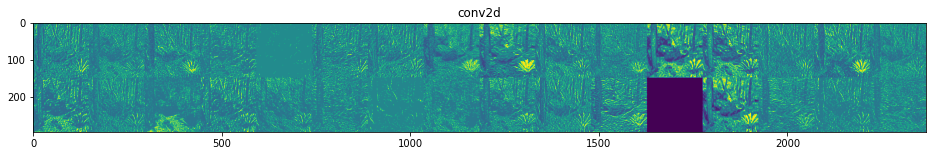

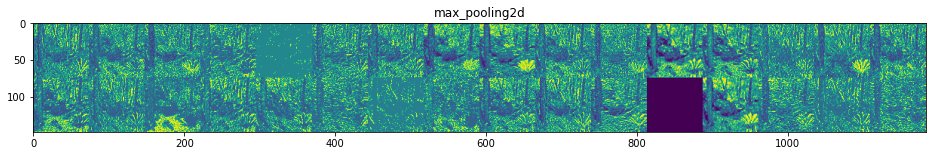

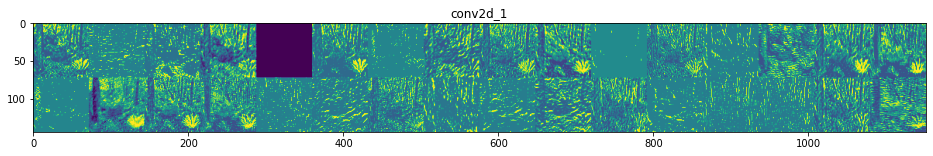

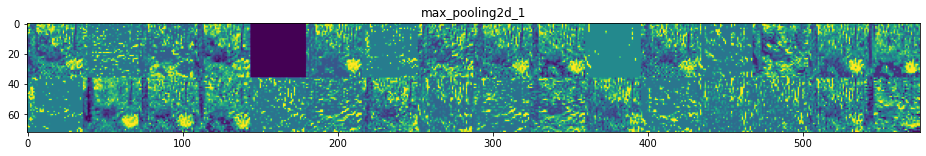

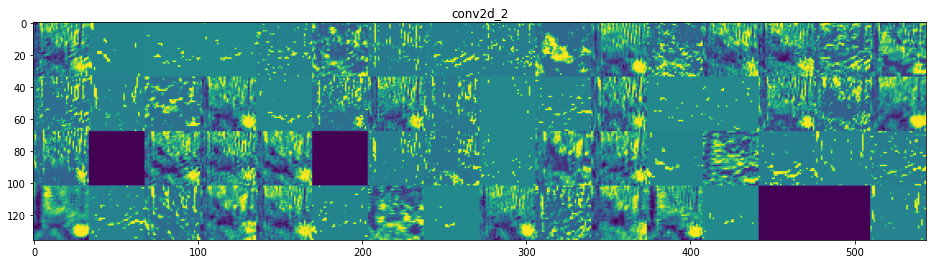

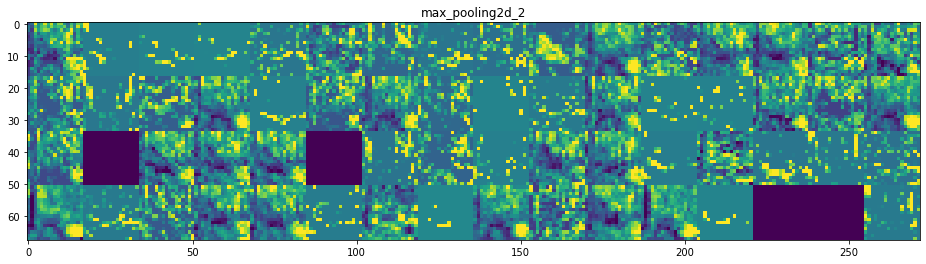

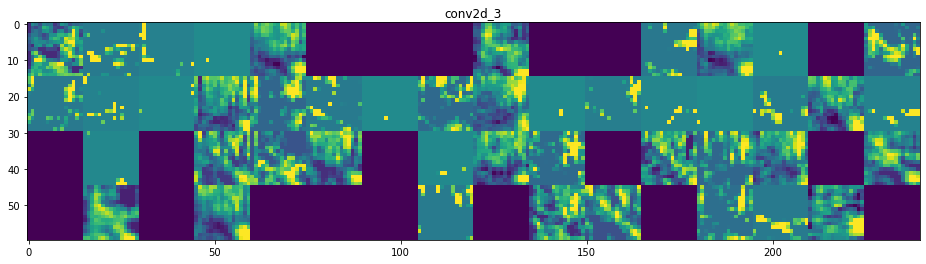

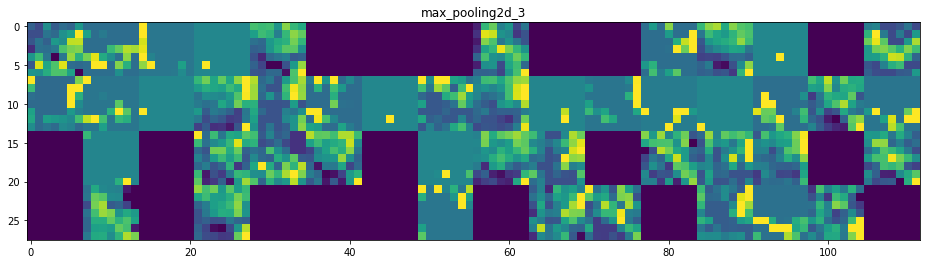

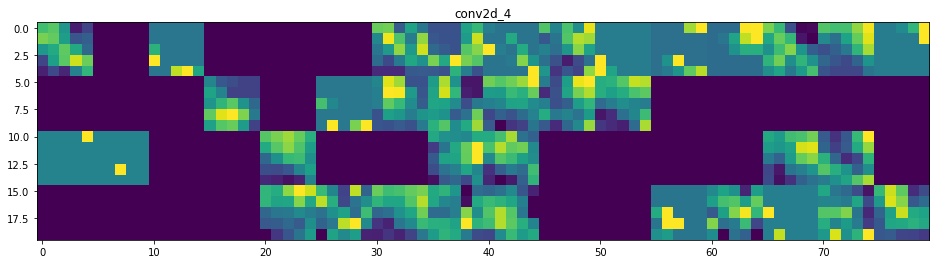

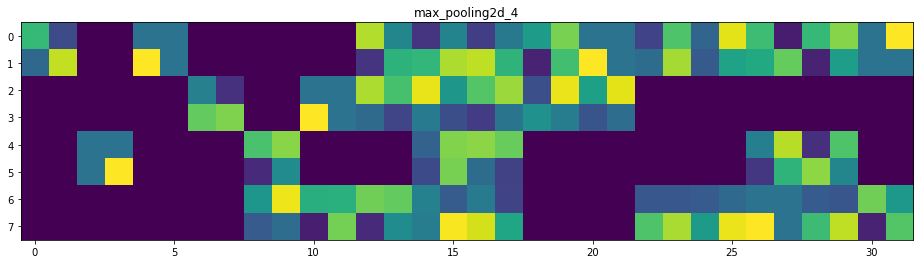

In [50]:
layer_names = []
for layer in model3.layers[:10]:  # iterate through each layer
    layer_names.append(layer.name)
    
images_per_row = 16 

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # features in featuremap
    
    size = layer_activation.shape[1] # shape of featuremap
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size)) # display grid of all featuremaps in layer
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            channel_image -= channel_image.mean() # post-precess of the featuremap
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size: (col + 1)*size,
                         row*size: (row + 1)*size] = channel_image
    scale = 1./size
    
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Note:

1. Initial layers extracts all edges from the input images and activation retains all the information from initial picture

2. As you go deeper into layers, activations become incresingly abstract and captures more specific information from input picture rather than extracting all the information.

3. In later stages of layers, activations ratain more information releated to class of the image. also, the sparsity of the activations increses with the depth of the layer. this means the pattern encoded by filter in these layers isn't found in input images.

Visualizing what each layer's activation learns gives idea on workings on CNN models. Just like human vision sees scenaries and our brain processes the information, CNN tries to do the same by extracting absract of each image to classify them into their respective class.

# Conclusions:

1. In this notebook, We built 2 Deep Neural network models using CNN layers.
2. Our first model's accuracy was at around 78% and our second model's accuracy improved to 87% which is significant in our problem.
3. We saw workings of CNN layer with key parameters and their description. we also learned about VGG16 pretrained base and its architecture.
4. Finally, we visualized intermediate activations of each layer of model1.